In [1]:
import cnot_network

from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sbs
import numpy as np
sbs.set_context("paper")
sbs.set_theme()
sbs.set_style("dark")

from surface_code_routing.tikz_utils import tikz, tex

sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
    
def plt_data_multi(data, x_axis, y_axis, **targets):
    idx_map = {j:i for i, j in enumerate(data)}
    rev_map = {j:i for i, j in idx_map.items()}

    iters = zip(*[iter(data[rev_map[i]]) for i, _ in enumerate(data)])

    x = []
    y = []
    for it in iters:
        checks = True
        for targ in targets:
            if it[idx_map[targ]] != targets[targ]:
                checks = False
        if not checks:
            continue
            
        x.append(it[idx_map[x_axis]])
        y.append(it[idx_map[y_axis]])
    return {'x':x, 'y':y}

In [2]:
from functools import partial
from surface_code_routing.lib_instructions import T_Factory, Toffoli, T_gate

toff_height = 14
toff_width = toff_height

t_factory_l1 = T_Factory()
toffoli_gate = Toffoli

t_factory_l2 = T_Factory(t_factory_l1, height=8, width=10, t_gate=T_gate(t_factory_l1))
t_gate_l2 = T_gate(factory=t_factory_l2)

t_factory_l3 = T_Factory(t_factory_l2, height=11, width=12, t_gate=T_gate(t_factory_l2))
t_gate_l3 = T_gate(factory=t_factory_l3)

extern_toffoli_l1 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l1)
extern_toffoli_l2 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l2)
extern_toffoli_l3 = cnot_network.toffoli(toff_height, toff_width, t_factory=t_factory_l3)

# Raw T injection sites
ccz_factory_l1 = cnot_network.CCZ_factory(6, 4, t_factory=None)
ccz_factory_l2 = cnot_network.CCZ_factory(9, 7, t_factory=t_factory_l1)
ccz_factory_l3 = cnot_network.CCZ_factory(11, 11, t_factory=t_factory_l2)

t_factories = (t_factory_l1, t_factory_l2, t_factory_l3)
extern_toffolis = (extern_toffoli_l1, extern_toffoli_l2, extern_toffoli_l3)
ccz_factories = (ccz_factory_l1, ccz_factory_l2, ccz_factory_l3)

ccz_factory_l2_4 = cnot_network.CCZ_factory(14, 14, t_factory=t_factory_l1)
ccz_factory_l3_4 = cnot_network.CCZ_factory(20, 22, t_factory=t_factory_l2)
ccz_factories_fast = (ccz_factory_l2_4, ccz_factory_l3_4)


In [10]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'adder':[]}
sizes = [32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 4
max_reg = 20

for reg_size in range(min_reg, max_reg + 1, 2):
    for size in sizes:
        for distillery, extern in zip((2, 3), ccz_factories_fast):
            print(f"\r Compiling: {reg_size} / {reg_size // 2} {size} {distillery}" + " " * 5, flush=True, end='')
            try:
                qcb = Division(reg_size, reg_size // 2, size, size, extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['adder'].append(reg_size)
            except: # This will likely be an allocation size issue
                pass
        
results_div_fast = results

 Compiling: 20 / 10 64 3     

In [13]:
results_div_fast = {'height': [32, 32, 48, 48, 64, 64, 32, 32, 48, 48, 64, 64, 32, 32, 48], 'distillery': [2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2], 'volume': [329312, 7590775, 323531, 6733862, 327530, 6698165, 625024, 14646133, 605186, 12801960, 605705, 12514216, 1075235, 24806847, 940790], 'runtime': [1244, 42533, 946, 10683, 926, 10682, 2264, 77991, 1708, 19565, 1379, 19563, 3587, 124080, 2177], 'adder': [4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 8, 8, 8]}

In [6]:
from functools import partial

import qmpa
from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard
from surface_code_routing.lib_instructions import Toffoli, T, T_Factory

import cnot_network

from surface_code_routing.compiled_qcb import compile_qcb

# Default Gates
GATE_MAP = {
    qmpa.gates.X : X,
    qmpa.gates.CNOT : CNOT,
    qmpa.gates.Toffoli : Toffoli,
}

def circ_to_dag(qmpa_circ, dag_symbol, gate_map=GATE_MAP, toffoli=Toffoli, init=True):

    dag = DAG(dag_symbol)

    # Local copy
    gate_map = dict(gate_map)
    
    gate_map[qmpa.gates.Toffoli] = toffoli
    
    if init:
        for i in range(qmpa_circ.allocator.max_mem):
            dag.add_gate(INIT(f'reg_{i}'))

    for gate in qmpa_circ.circuit:
        dag_gate = gate_map.get(type(gate), None)
        if dag_gate is None:
            continue

        args = gate.qargs()
        dag.add_gate(
                dag_gate(
                    *list(
                        map(lambda x: "reg_{x}".format(x=x), args)
                        )
                    )
                )
    return dag 

In [7]:
import numpy as np
from functools import reduce, partial

from surface_code_routing.dag import DAG
from surface_code_routing.symbol import Symbol 
from surface_code_routing.instructions import INIT, CNOT, MEAS, X, Hadamard
from surface_code_routing.lib_instructions import T_Factory, CSWAP

from surface_code_routing.compiled_qcb import compile_qcb

import qmpa

def qmpa_in_place_operation(operation, readout_assert, *values, register_size = None):
    assert all(lambda x: type(x) is int for x in values)

    if register_size is None:
        register_size = int(np.ceil(np.log2(max(values))))

    circ = qmpa.circuit.Circuit()
    
    reg_carry = circ.register(1, 'carry')
    registers = [circ.register(register_size + i, 'reg_{}'.format(i), value) for i, value in enumerate(values)]
               
    reduce(partial(operation(circ), reg_carry=reg_carry), registers) 
    
    return circ


def qmpa_multiplication(*values, register_size = None):
    assert all(lambda x: type(x) is int for x in values)


    if register_size is None:
        register_size = int(np.ceil(np.log2(max(values)))) + 1

    circ = qmpa.circuit.Circuit()
    
    reg_carry = circ.register(1, 'carry')
    registers = [circ.register(register_size, 'reg_{}'.format(i), value) for  i, value in enumerate(values)]
              
    prev_reg = registers[0]
    for register in registers[1:]:
       prev_reg = circ.multiply(prev_reg, register)
        
    assert reduce(lambda x, y: x * y, values) == circ.readout(prev_reg)[0]
    return circ


qmpa_addition = partial(qmpa_in_place_operation, lambda x: x.add, lambda vals: reduce(lambda x, y: x + y, vals))
qmpa_subtraction = partial(qmpa_in_place_operation, lambda x: x.subtract, lambda vals: reduce(lambda x, y: x - y, vals))

def qmpa_division(*values, register_sizes = None):
    assert all(lambda x: type(x) is int for x in values)


    if register_sizes is None:
        register_sizes = [int(np.ceil(np.log2(i))) + 1 for i in values]

    circ = qmpa.circuit.Circuit()
    
    reg_carry = circ.register(1, 'carry')
    registers = [circ.register(register_size, 'reg_{}'.format(i), value) for  i, (value, register_size) in enumerate(zip(values, register_sizes))]
              
    prev_reg = registers[0]
    for register in registers[1:]:
       prev_reg = circ.divide(prev_reg, register) 
    
    return circ

In [8]:
toffoli_gate = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

def CCPY(n_qubits, height, width, *externs, toffoli_gate=Toffoli, **kwargs):
    assert (width >= n_qubits * 2 + 1)
    dag = DAG(Symbol(
        f"CCPY",
        tuple(['ctrl'] + [f'q_{i}' for i in range(n_qubits)]),
        tuple(['ctrl'] + [f'q_{i}' for i in range(n_qubits)] + [f'o_{i}' for i in range(n_qubits)]))
             )
    for i in range(n_qubits):
        dag.add_gate(toffoli_gate('ctrl', f'q_{i}', f'o_{i}'))
    return compile_qcb(dag, height, width, *externs, **kwargs)

In [9]:
def Division(n_qubits_a, n_qubits_b, height, width, *externs, toffoli_gate=toffoli_gate, extern=False):
    n_qubits = 3
    qmpa_obj = qmpa_division(1 << n_qubits_a, 1 << n_qubits_b)
    input_registers = [f'reg_{i}' for i in range(n_qubits * 2)]
    output_registers =  [f'reg_{i}' for i in range(qmpa_obj.allocator.max_mem)]

    if extern:
        sym = Symbol(f'DIV_{n_qubits_a}_{n_qubits_b}', input_registers, output_registers)
    else:
        sym = Symbol(f'DIV_{n_qubits_a}_{n_qubits_b}')
    
    dag = circ_to_dag(
        qmpa_obj,
        sym, 
        toffoli=toffoli_gate,
        init=False)
    return compile_qcb(dag, height, width, *externs)

In [ ]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'adder':[]}
sizes = [32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 4
max_reg = 32

for reg_size in range(min_reg, max_reg + 1, 2):
    for size in sizes:
        for distillery, extern in zip((1, 2, 3), ccz_factories):
            print(f"\r Compiling: {reg_size} / {reg_size // 2} {size} {distillery}" + " " * 5, flush=True, end='')
            try:
                qcb = Division(reg_size, reg_size // 2, size, size, extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['adder'].append(reg_size)
            except: # This will likely be an allocation size issue
                pass
        
results_div = results

 Compiling: 6 / 3 48 1     

In [7]:
results = {'height':[], 'distillery':[], 'volume':[], 'runtime':[], 'adder':[]}
sizes = [32, 48, 64]

toffoli = partial(cnot_network.toffoli_from_ccz, ccz_factory=ccz_factory_l1)

min_reg = 22
max_reg = 32

for reg_size in range(min_reg, max_reg + 1, 2):
    for size in sizes:
        for distillery, extern in zip((1, 2, 3), ccz_factories):
            print(f"\r Compiling: {reg_size} / {reg_size // 2} {size} {distillery}" + " " * 5, flush=True, end='')
            try:
                qcb = Division(reg_size, reg_size // 2, size, size, extern)
                results['height'].append(size)
                results['distillery'].append(distillery)
                results['volume'].append(qcb.space_time_volume())
                results['runtime'].append(qcb.n_cycles())
                results['adder'].append(reg_size)
            except: # This will likely be an allocation size issue
                pass
        
results_div = results

 Compiling: 32 / 16 64 3     

In [15]:
results_div = {'height': [32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32, 48, 48, 48, 64, 64, 64, 32, 48, 48, 64, 64, 64, 32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32, 32, 48, 48, 48, 64, 64, 64, 32, 32], 'distillery': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 3, 1, 2, 3, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2], 'volume': [43079, 468618, 9346308, 47456, 462911, 9540645, 46161, 492674, 9973388, 85179, 910194, 18316237, 101920, 878946, 18184260, 100971, 885111, 17924241, 150892, 1525403, 30724178, 180792, 1493961, 28872824, 192550, 1499572, 29376401, 240646, 2142326, 48164440, 301233, 2361423, 44104145, 306460, 2334916, 45900973, 354301, 3031037, 68094094, 423599, 3094083, 59006870, 483903, 3238662, 62069424, 507887, 93906392, 580889, 4311348, 80160026, 683980, 4460455, 82711297, 740474, 820379, 5719485, 946219, 5956746, 110312909, 955469, 7274503, 161200170, 1076282, 7474027, 132932909, 1242954, 7725546, 143204042, 1204708, 9223254, 195090458, 1363246, 9396715, 167559051, 1570769, 9384228, 177611336, 1524890, 11138786], 'runtime': [513, 2869, 42058, 506, 2870, 42038, 501, 2870, 42042, 907, 5239, 77083, 898, 4265, 77043, 913, 4272, 63013, 1430, 8370, 123691, 1417, 6657, 98105, 1410, 6668, 98056, 2065, 9795, 179804, 2062, 9748, 144658, 2056, 9783, 144661, 2801, 11174, 245201, 2774, 11085, 163493, 2798, 11088, 163491, 3660, 322260, 3621, 14551, 214861, 3654, 14561, 214862, 4650, 4610, 18489, 4616, 18492, 273235, 5758, 23101, 508859, 5695, 22893, 338620, 5673, 22916, 338615, 6992, 28029, 616466, 6903, 27800, 411002, 6865, 27790, 411001, 8315, 33437], 'adder': [4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 14, 14, 16, 16, 16, 16, 16, 16, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22, 22]}

Text(0.5, 0.01, '$n /  \\frac{n}{2}$ Trial Division')

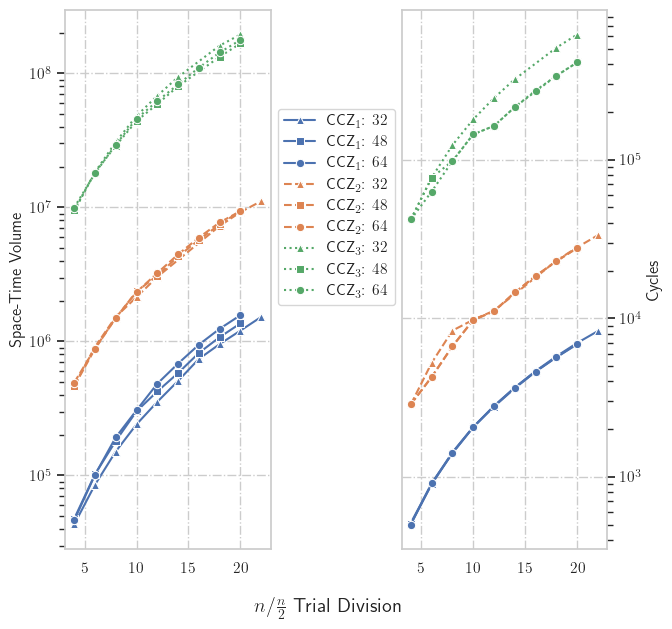

In [16]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})

#locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=20)  
#ax.yaxis.set_minor_locator(locmin)
#ax.yaxis.set_minor_formatter(mticker.NullFormatter())
#plt.grid(True,which="both")  


marks = ['^', 's', 'o', 'v']
linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'adder'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_div,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_div,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
    
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$n /  \\frac{n}{2}$ Trial Division')


#sbs.lineplot(x=results_extern['n_ctrl'], y=results_extern['volume'], label="Toffoli Extern")
#sbs.lineplot(x=results_ccz['n_ctrl'], y=results_ccz['volume'], label='Toffoli Factory', **ccz_style, marker='^')


#plt.title('Toffoli Runtimes for Various QCB Sizes')
#plt.xlabel('C$^{n}$X')
#plt.ylabel('Space-Time Volume')c8

#plt.yscale('log')

#plt.legend()

#plt.savefig('div_qmpa.pdf')

Text(0.5, 0.01, '$n /  \\frac{n}{2}$ Trial Division')

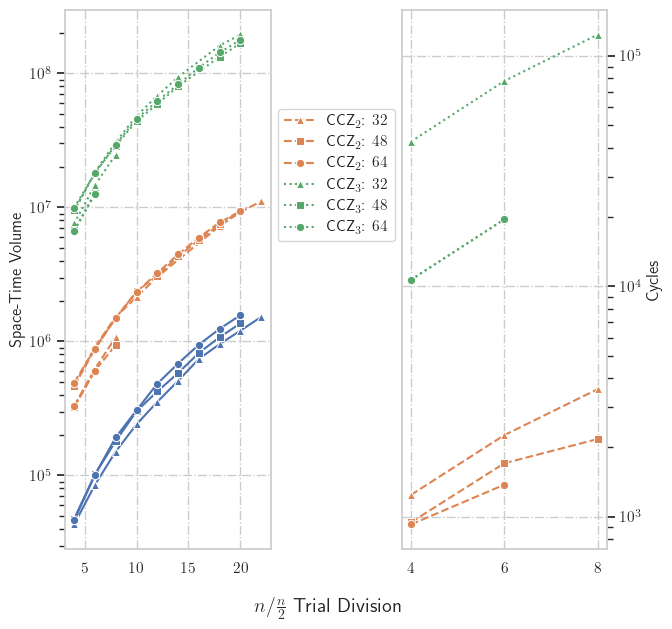

In [17]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

#f, ax = plt.subplots(figsize=(7, 7))


sbs.set_theme()
sbs.set_style("dark")
sbs.set_style("whitegrid", {'grid.linestyle': '-.'})



marks = ['^', 's', 'o', 'v']
linestyles = ['-', '--', ':']

target_key = 'distillery'
dependent = 'volume'
independent = 'adder'
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 7))

ax = [
    plt.subplot2grid((1, 5), (0, 0), colspan=2),
    plt.subplot2grid((1, 5), (0, 3), colspan=2)
]

subplot = ax[0]
kwargs = {
'errorbar':('ci', 100)
}


for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_div,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )

for idx, target in enumerate((1, 2, 3)):
    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_div_fast,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'Fast CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
subplot.legend_.remove()
subplot.yaxis.set_label_position("left")
subplot.yaxis.tick_left()
subplot.set_yscale('log')
subplot.set_ylabel('Space-Time Volume')

dependent = 'runtime'

subplot = ax[1]
for idx, target in enumerate((1, 2, 3)):

    for jdx, size in enumerate(sizes):
        obj = sbs.lineplot(
            ax=subplot,
            **plt_data_multi(
                results_div_fast,
                independent,
                dependent,
                height=size,
                **{target_key:target}
            ),
            label=f'CCZ$_{target}$: ${size}$',
            linestyle=linestyles[idx],
            marker=marks[jdx],
            color=sbs.color_palette()[idx],
            **kwargs
        )
    
subplot.legend_.remove()
subplot.yaxis.set_label_position("right")
subplot.yaxis.tick_right()
subplot.set_yscale('log')
subplot.set_ylabel('Cycles')

fig = plt.gcf()
fig.set_size_inches(7, 7)

lines = linestyles * 3
labels = sum(([f'DAG$_{target}$', f'Extern$_{target}$', f'CCZ$_{target}$'] for target in range(3)), start=list())

handles, labels = subplot.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper left', bbox_to_anchor=(0.419, 0.75))
fig.supxlabel('$n /  \\frac{n}{2}$ Trial Division')

